In [85]:
import os
import ast
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [87]:
# === CONFIG ===
LABEL_FILE = "/kaggle/input/labels/label_finalized 1.txt"
IMAGE_DIR = "/kaggle/input/train-data/Final_Data"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 20
CLASS_INDEX_PATH = "/kaggle/working/class_indices_effnet.npy"

In [88]:
# === Load and Encode Labels ===
data = []
with open(LABEL_FILE, "r") as f:
    for line in f:
        parts = line.strip().split(None, 1)
        if len(parts) == 2:
            filename = parts[0].strip('"')
            brand = ast.literal_eval(parts[1])[0].strip().lower()
            data.append({"filename": filename, "brand": brand})

df = pd.DataFrame(data)
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["brand"])
class_names = label_encoder.classes_
num_classes = len(class_names)
np.save(CLASS_INDEX_PATH, class_names)

# === Preprocess Images ===
def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB").resize(IMAGE_SIZE)
    return img_to_array(img) / 255.0

X = []
y = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    path = os.path.join(IMAGE_DIR, row["filename"])
    if os.path.exists(path):
        try:
            X.append(preprocess_image(path))
            y.append(row["label"])
        except:
            print(f"Error loading {path}")

X = np.stack(X)
y = tf.keras.utils.to_categorical(y, num_classes=num_classes)

100%|██████████| 2720/2720 [00:31<00:00, 85.68it/s] 


In [89]:
# === Split into Train/Val ===
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [90]:
# === Compute Class Weights ===
y_labels = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_labels), y=y_labels)
class_weights = dict(enumerate(class_weights))

In [92]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.3,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    fill_mode='nearest'
)

In [93]:
# === Model Definition ===
base_model = EfficientNetV2B0(
    include_top=False,
    input_tensor=Input(shape=(224, 224, 3)),
    weights="imagenet"
)
base_model.trainable = False  # Freeze base

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation="softmax", kernel_regularizer=l2(1e-4))(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [94]:
# === Callbacks ===
early_stop = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)

In [95]:
# === Train ===
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


136/136 ━━━━━━━━━━━━━━━━━━━━ 141s 254ms/step - accuracy: 0.0367 - loss: 3.5795 - val_accuracy: 0.0276 - val_loss: 3.5628 - learning_rate: 1.0000e-04
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 28s 194ms/step - accuracy: 0.0340 - loss: 3.5550 - val_accuracy: 0.0386 - val_loss: 3.5920 - learning_rate: 1.0000e-04
Epoch 3/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 28s 194ms/step - accuracy: 0.0231 - loss: 3.5575 - val_accuracy: 0.0294 - val_loss: 3.6394 - learning_rate: 1.0000e-04
Epoch 4/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 28s 196ms/step - accuracy: 0.0255 - loss: 3.5450 - val_accuracy: 0.0331 - val_loss: 3.6599 - learning_rate: 1.0000e-04
Epoch 5/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 29s 199ms/step - accuracy: 0.0360 - loss: 3.5314 - val_accuracy: 0.0368 - val_loss: 3.6687 - learning_rate: 1.0000e-04
Epoch 6/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 28s 194ms/step - accuracy: 0.0263 - loss: 3.5371 - val_accuracy: 0.0276 - val_loss: 3.7661 - learning_rate: 5.0000e-05
Epoch 7/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 28s 195ms/step -

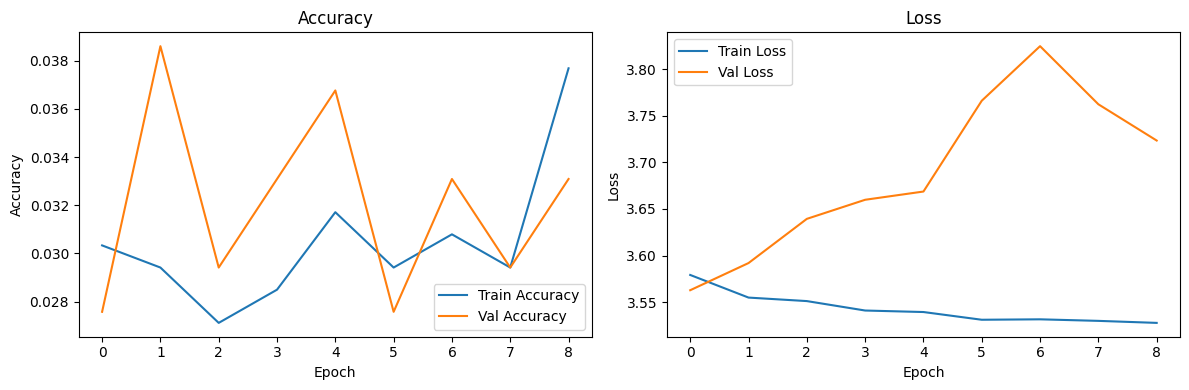

✅ EfficientNetV2 model saved.


In [96]:
# === Plot Training Curves ===
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig("efficientnet_training_plot.png")
plt.show()

# === Save Model ===
model.save("/content/efficientnetv2_finetuned.h5")
print("✅ EfficientNetV2 model saved.")

100%|██████████| 2720/2720 [00:30<00:00, 89.21it/s] 
/tmp/ipykernel_31/2193409275.py:88: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=Input(shape=(224, 224, 3)), weights="imagenet")


🔁 Warm-up phase: training top layers only
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


136/136 ━━━━━━━━━━━━━━━━━━━━ 39s 204ms/step - accuracy: 0.0355 - loss: 4.0762 - top_k_categorical_accuracy: 0.0917 - val_accuracy: 0.0276 - val_loss: 3.6602 - val_top_k_categorical_accuracy: 0.0901 - learning_rate: 1.0000e-04
Epoch 2/5
136/136 ━━━━━━━━━━━━━━━━━━━━ 25s 172ms/step - accuracy: 0.0255 - loss: 3.6690 - top_k_categorical_accuracy: 0.0821 - val_accuracy: 0.0239 - val_loss: 3.6284 - val_top_k_categorical_accuracy: 0.0864 - learning_rate: 1.0000e-04
Epoch 3/5
136/136 ━━━━━━━━━━━━━━━━━━━━ 25s 171ms/step - accuracy: 0.0219 - loss: 3.5878 - top_k_categorical_accuracy: 0.0779 - val_accuracy: 0.0129 - val_loss: 3.6169 - val_top_k_categorical_accuracy: 0.0790 - learning_rate: 1.0000e-04
Epoch 4/5
136/136 ━━━━━━━━━━━━━━━━━━━━ 25s 171ms/step - accuracy: 0.0335 - loss: 3.5453 - top_k_categorical_accuracy: 0.1030 - val_accuracy: 0.0129 - val_loss: 3.6202 - val_top_k_categorical_accuracy: 0.0680 - learning_rate: 1.0000e-04
Epoch 5/5
136/136 ━━━━━━━━━━━━━━━━━━━━ 25s 172ms/step - accuracy: 

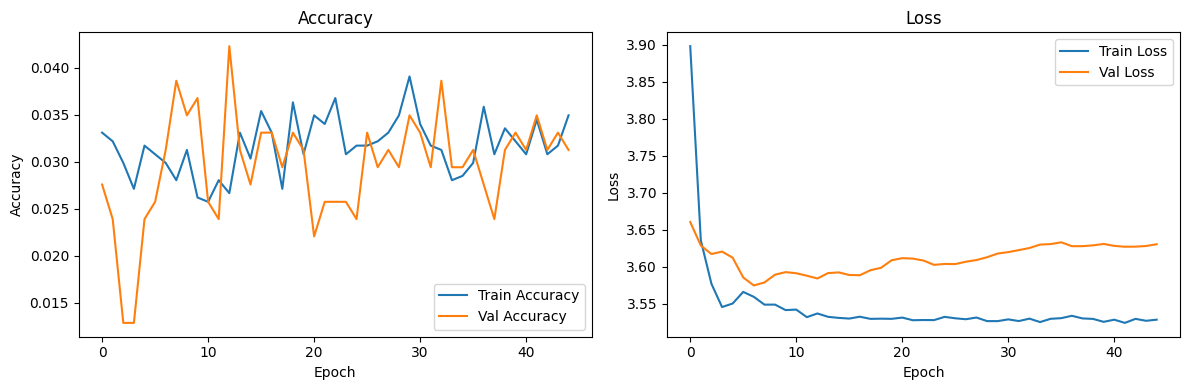

✅ Final MobileNetV2 model saved.
